In [1]:
%load_ext autoreload
%autoreload 2

In [10]:

import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


### Compare Gold Standard with Matlab toolbox
* #### Make common dataframe with Tail active from both algorithm (use dataframe from G:\ZebrafishBoutsDataset for matlab reference)
* #### Compute confusion matrix for python gold standard (with different N in KNN) vs Matlab
* #### Compute confusion matrix for sparse coding segmentation vs threshold based



# Prepare Pipeline

In [11]:
from preprocessing.smoothing import create_preprocess
from sparse_coding.sparse_coding import create_sparse_coder
from segmentation.segment import create_segmentation_from_code
from classification.classify import create_classifier
from classification.template_bouts import generate_template_bouts


from super_resolution.downsampling import convert_duration
from utils.utils_bouts import compute_bout_cat_ts

In [12]:
def create_pipeline(preprocess,sparse_coder,segment_from_code,classifier):

    def pipeline(tail_angle)-> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:

        tail_angle_clean = preprocess(tail_angle)
        z,tail_angle_hat = sparse_coder(tail_angle_clean)
        onset,offset,bouts_array = segment_from_code(z,tail_angle)
        bouts_array_flat = np.reshape(np.swapaxes(bouts_array, 1, 2),(bouts_array.shape[0],bouts_array.shape[1]*bouts_array.shape[2]))
        bout_cat,delay_pred,id_nearest= classifier(bouts_array_flat)

        bout_cat_ts,bout_cat_ts_signed = compute_bout_cat_ts(onset,offset,bout_cat,tail_angle.shape[0])
                
        return 
        (tail_angle_clean,
         z,tail_angle_hat,
         onset,
         offset,
         bouts_array,
         bout_cat,
         delay_pred,
         id_nearest,
         bout_cat_ts,
         bout_cat_ts_signed)
         
    return pipeline

In [13]:
new_fps = 700
Max_Delay = convert_duration(70,original_fps=700,new_fps=new_fps)
Step_Delay = convert_duration(3,original_fps=700,new_fps=new_fps)

templates_flat,templates_labels,templates_delays,NameCat,Duration_after_Downsampling = generate_template_bouts(format='tail',target_fps=new_fps,ExludeCaptureSwim=True,delays=np.arange(-10,10,3))
#templates_flat,templates_labels,templates_delays,NameCat,Duration_after_Downsampling = generate_template_bouts(format='tail',target_fps=new_fps,ExludeCaptureSwim=True,delays=np.arange(0,Max_Delay,Step_Delay))

Dict = np.load('./sparse_coding/3atomsDictTu.npy')


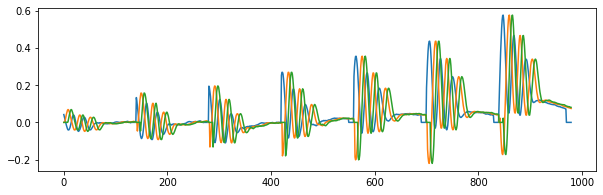

In [ ]:

M = int(len(np.unique(templates_delays)))
N = int(len(templates_delays)/(M*2))
plt.figure(figsize=(10,3))

plt.plot(templates_flat[0,:])
plt.plot(templates_flat[0+N*int(np.round(M/2)),:])
plt.plot(templates_flat[0+N*(M-1),:])
plt.show()

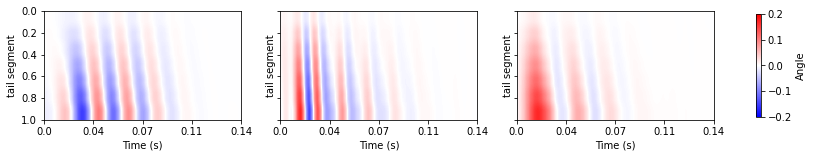

In [7]:

D = Dict

fig, (ax) = plt.subplots(1,3,figsize=(15,2), sharex=True,sharey=True)#,constrained_layout=True)

for i in range(D.shape[-1]):
    #ax[i].title(str(i))
    im = ax[i].imshow(D[:,:,i].T,aspect='auto',vmin=-0.2,vmax=0.2,cmap='bwr',extent=[0,100,1,0])
    ax[i].set_ylabel('tail segment')
    #ax[i,0].set_xlabel('Time (s)')
    ax[i].set_xticks(np.linspace(0,100,5))
    ax[i].set_xticklabels(np.round(np.linspace(0,100/700,5),2))


ax[0].set_xlabel('Time (s)')
ax[1].set_xlabel('Time (s)')
ax[2].set_xlabel('Time (s)')

cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.95)
cbar.set_label('Angle')
plt.show()

In [8]:
# Check difference between tail or tail&traj or traj using the scale:
#scale = [1.6]*7+[0.5,0.4,1] # tail & traj
#scale = [0.5,0.4,1]  # traj
scale = [1]*7 # tail

In [103]:
preprocess = create_preprocess(limit_na=5,num_pcs=4)
sparse_coder = create_sparse_coder(Dict,lmbda=0.01,gamma=0.05,mu=0.05,Whn=60)
segment_from_code = create_segmentation_from_code(Min_Code_Ampl=1,SpikeDist=120,Bout_Duration=140)
classifier = create_classifier(templates_flat,templates_labels,templates_delays,scale,n_neighbors=15,Bout_Duration=140)
pipeline = create_pipeline(preprocess,sparse_coder,segment_from_code,classifier)

# Load Data


In [124]:
df = pd.read_csv('D:\ZebrafishMatlabCSV\CatchAllBouts_atlas_20200525_1551_df.csv')

In [105]:

NumSegment = sum(['tail_angle' in df.columns[i] for i in range(len(df.columns))])
relative_tail_angle = df[['tail_angle_'+str(i).zfill(2) for i in range(1,NumSegment+1)]]
relative_tail_angle = relative_tail_angle.values
tail_angle_init=np.cumsum(relative_tail_angle,1)
tail_angle = np.copy(tail_angle_init)
tail_angle[tail_angle<-10]=np.nan # Set Nan when tail angle out of range:


In [106]:
tail_angle.shape

(8908250, 10)

In [107]:
#  Runing full pipeline
tail_angle_clean,z,tail_angle_hat,onset,offset,bouts_array,bout_cat,delay_pred,id_nearest,bout_cat_ts,bout_cat_ts_signed = pipeline(tail_angle)

Itn   Fnc       DFid      Regℓ1     RegLat    RegSelf   r         s         ρ       
------------------------------------------------------------------------------------
   0  5.87e+04  3.00e+04  3.51e+05  3.02e+05  2.01e+05  4.33e-01  2.00e+01  1.50e+00
   1  9.07e+04  2.22e+04  4.26e+05  7.57e+05  5.27e+05  5.58e-01  3.31e+00  1.50e+00
   2  1.12e+05  2.54e+04  4.11e+05  9.51e+05  6.90e+05  4.39e-01  4.69e-01  5.99e-01
   3  1.21e+05  2.59e+04  3.47e+05  1.02e+06  8.19e+05  3.16e-01  2.05e-01  5.99e-01
   4  1.20e+05  2.82e+04  2.94e+05  9.44e+05  8.30e+05  2.44e-01  1.52e-01  7.24e-01
   5  1.19e+05  2.97e+04  2.59e+05  8.78e+05  8.49e+05  1.60e-01  1.35e-01  8.93e-01
   6  1.22e+05  3.07e+04  2.51e+05  8.72e+05  9.09e+05  1.13e-01  1.11e-01  8.93e-01
   7  1.24e+05  3.10e+04  2.46e+05  8.65e+05  9.46e+05  9.84e-02  8.75e-02  8.93e-01
   8  1.24e+05  3.16e+04  2.37e+05  8.43e+05  9.63e+05  8.58e-02  7.25e-02  8.93e-01
   9  1.24e+05  3.22e+04  2.29e+05  8.13e+05  9.83e+05  7.11e-02 

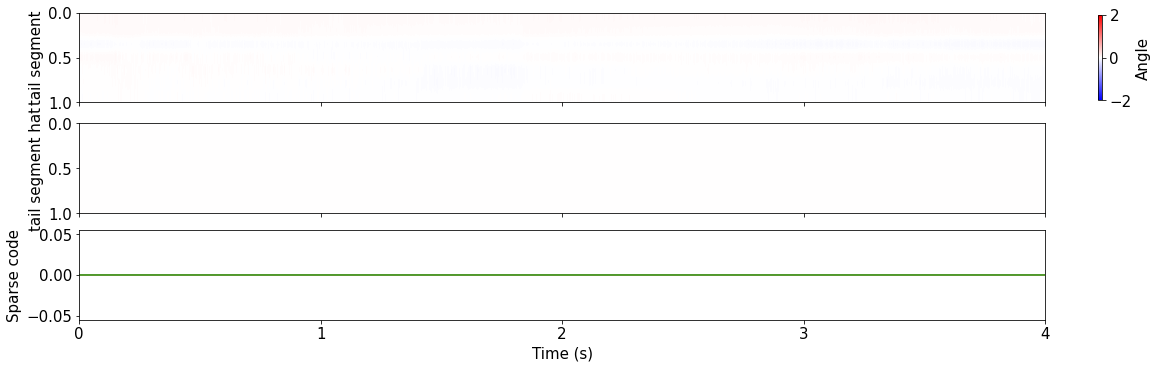

In [108]:
Duration = 700*5
IdSt= np.random.randint(z.shape[0]-Duration)

fig, (ax) = plt.subplots(3,1,figsize=(16,5), sharex=True,constrained_layout=True)
im = ax[0].imshow(tail_angle[IdSt:IdSt+Duration,:7].T,aspect='auto',extent=[0,Duration,1,0],vmin=-2,vmax=2,cmap='bwr',interpolation=None)
ax[0].set_ylabel('tail segment')
im = ax[1].imshow(tail_angle_hat[IdSt:IdSt+Duration,:7].T,aspect='auto',extent=[0,Duration,1,0],vmin=-2,vmax=2,cmap='bwr',interpolation=None)
ax[1].set_ylabel('tail segment hat')
ax[2].plot(z[IdSt:IdSt+Duration,:])
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Sparse code')
ax[2].set_xticks(np.linspace(0,Duration,5))

ax[2].set_xticklabels(np.arange(0,5))

cbar = fig.colorbar(im, ax=ax[0], shrink=0.95)
cbar.set_label('Angle')
plt.show()

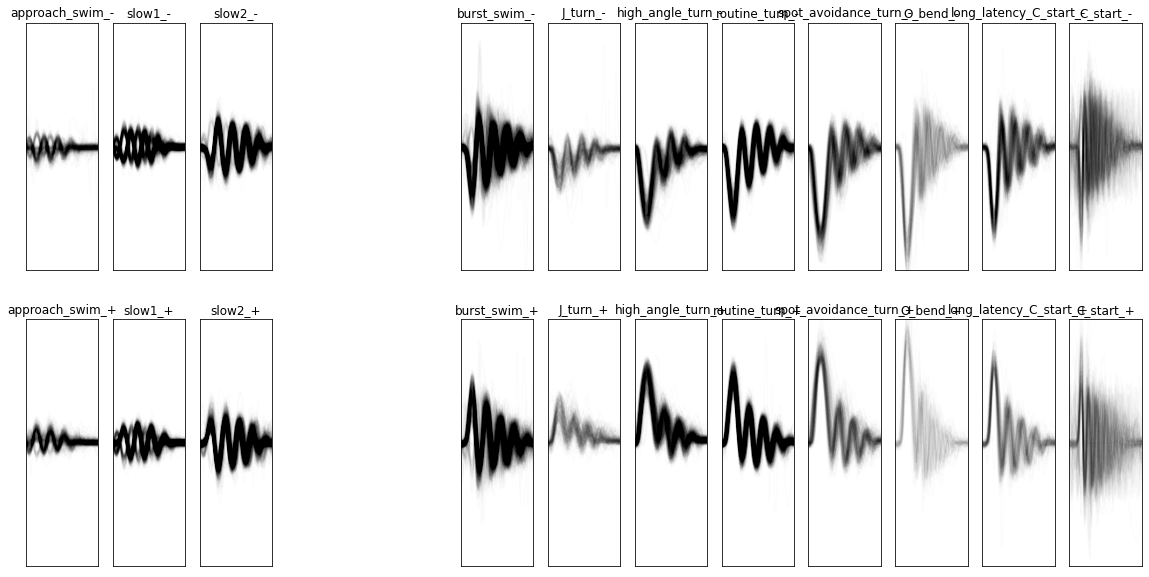

In [109]:
import matplotlib.gridspec as gridspec
from matplotlib import colors

fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,13)
ax0 = {}

for k,b in enumerate(np.unique((templates_labels))):
    b = int(b)
    sg = 1 if b<13 else -1
    ax0 = plt.subplot(G[int((sg+1)*1/2),b%13])
    ax0.set_title(NameCat[b])
    
    id = np.where(bout_cat==b)[0]       
    if len(id)>0:
        id = id[0:1000]
        ax0.plot(bouts_array[id,:,-1].T,'k',alpha=0.01)

    ax0.set_xlim(0,120)
    ax0.set_ylim(-3.6,3.6)
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    
plt.show()


# Check Agreement with Matlab

In [117]:
'''bout_cat_matlab = df.bout_sign_matlab.values
bout_cat_matlab[df.tail_active.values==0]=-1

bout_cat_unsigned = bout_cat
bout_cat_unsigned[bout_cat_unsigned>-1]=bout_cat_unsigned[bout_cat_unsigned>-1]%13'''

'bout_cat_matlab = df.bout_sign_matlab.values\nbout_cat_matlab[df.tail_active.values==0]=-1\n\nbout_cat_unsigned = bout_cat\nbout_cat_unsigned[bout_cat_unsigned>-1]=bout_cat_unsigned[bout_cat_unsigned>-1]%13'

In [125]:
from classification.benchmark_w_matlab import compute_bout_cat_matlab
from scipy import stats

onset_mat,offset_mat,bout_cat_matlab,bout_cat_ts_matlab,bout_cat_ts_signed_matlab = compute_bout_cat_matlab(df)

label_mat = []
label_py = []

for i,(on_,off_) in enumerate(zip(onset_mat,offset_mat)):
    tmp = bout_cat_ts[on_:off_]
    tmp = tmp[tmp>-1]
    if len(tmp)>0:
        label_mat.append(bout_cat_matlab[i])
        label_py.append(stats.mode(tmp)[0][0])

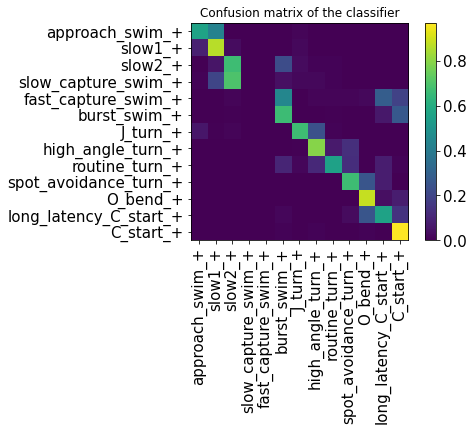

In [127]:
from sklearn.metrics import confusion_matrix
x = np.array(label_mat)
y = np.array(label_py)

cm = confusion_matrix(x, y, labels = np.arange(13),normalize='true')#{‘true’, ‘pred’, ‘all’,'none})
plt.imshow(cm)
plt.title('Confusion matrix of the classifier')
plt.colorbar()
plt.xticks(np.arange(13),NameCat[0:13],rotation=90)
plt.yticks(np.arange(13),NameCat[0:13],rotation=0)
plt.show()

In [128]:
# Accuracy:
x_noCS = x[(x!=3)&(x!=4)]
y_noCS = y[(x!=3)&(x!=4)]

In [129]:
from sklearn.metrics import f1_score
f1_score(x_noCS, y_noCS, average='macro')

0.5658689377122799

In [130]:
from sklearn.metrics import accuracy_score
accuracy_score(x_noCS, y_noCS)

0.6871243277443847

In [131]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(x_noCS, y_noCS)

0.712364556249661

In [ ]:
0.7110439583131611 knn=3

# Display Time Series

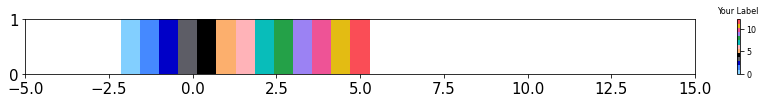

In [132]:
from utils.utils_plot import NameCatSym_w_CS,list_color_w_CS,cmp_bouts
plt.figure(figsize=(15,1))
plt.imshow(np.arange(-5,30)[:,np.newaxis].T,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=12,interpolation='nearest',extent=[-5,15,0,1])
clb=plt.colorbar()
clb.ax.tick_params(labelsize=8) 
clb.ax.set_title('Your Label',fontsize=8)
plt.show()

In [133]:
len(onset),len(bout_cat),bouts_array.shape,len(id_nearest)

(14410, 14410, (14410, 140, 7), 14410)

In [14]:

Duration = new_fps*7
IdSt = np.random.randint(tail_angle.shape[0])
IdEd = IdSt + Duration
t = np.linspace(0,Duration/new_fps,Duration)
sub_onset,sub_offset,sub_i= [],[],[]

for i,(on_,off_) in enumerate(zip(onset,offset)):
    if (on_>IdSt)&(off_<IdEd):
        sub_onset.append(on_)
        sub_offset.append(off_)
        sub_i.append(i)

sub_i = np.array(sub_i)
sub_onset = np.array(sub_onset)
sub_offset = np.array(sub_offset)

sub_bouts_array = bouts_array[sub_i,:,:]
id = id_nearest[sub_i]
Nearest_template = templates_flat[id,:]

sub_onset = sub_onset-IdSt
sub_offset = sub_offset-IdSt

NameError: name 'tail_angle' is not defined

NameError: name 't' is not defined

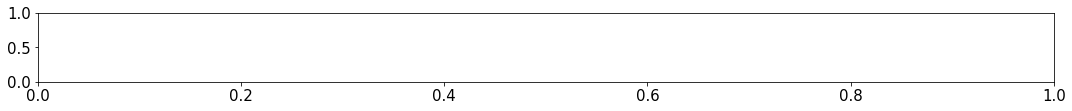

In [15]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(facecolor='white',figsize=(15,7),tight_layout=True,sharex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)


G = gridspec.GridSpec(5,1)

ax = plt.subplot(G[0])
#ax.plot(t,tail_angle[IdSt:IdEd,7],'k',lw=1)
ax.plot(t,tail_angle_clean[IdSt:IdEd,7],lw=1)
ax.plot(t,df.tail_active.values[IdSt:IdEd])
for p in sub_onset:
    ax.add_patch(Rectangle((t[p],-1),140/700,2,facecolor="red",alpha=0.3))
ax.set_xlim(0,Duration/new_fps)

ax = plt.subplot(G[1])
ax.plot(t,z[IdSt:IdEd,:])

ax.set_xlim(0,Duration/new_fps)


ax = plt.subplot(G[2])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    ax.plot((np.arange(on_,off_))/new_fps,tail_angle_clean[on_+IdSt:off_+IdSt,6],'tab:blue')
    off_ = on_+140
    ax.plot((np.arange(on_,off_))/new_fps,Nearest_template[i,140*6:],'tab:red',lw=1)
ax.set_xlim(0,Duration/new_fps)

ax = plt.subplot(G[3])
ax.imshow(bout_cat_ts_matlab[IdSt:IdEd,np.newaxis].T,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=12,interpolation='nearest',extent=[0,Duration/new_fps,0,1])
ax.set_xlim(0,Duration/new_fps)

ax = plt.subplot(G[4])
ax.imshow(bout_cat_ts[IdSt:IdEd,np.newaxis].T,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=12,interpolation='nearest',extent=[0,Duration/new_fps,0,1])
ax.set_xlim(0,Duration/new_fps)

# Plotly Save

In [38]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px


In [41]:
def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale


In [42]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

cmp_bouts = colors.ListedColormap(['#FFFFFF'] + list_color_w_CS)


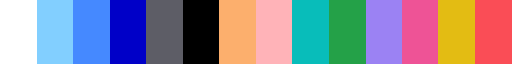

In [43]:
cmp_bouts

In [45]:
import plotly.express as px
import numpy as np

img = np.arange(-10,30).reshape(1,-1)
fig = px.imshow(img,color_continuous_scale=cmp_bouts,zmin=-1,zmax=13)

fig.write_html("free_swimming_pipeline.html")

ValueError: 
    Invalid value of type 'matplotlib.colors.ListedColormap' received for the 'colorscale' property of imshow
        Received value: <matplotlib.colors.ListedColormap object at 0x000001E35B9A9D30>

    The 'colorscale' property is a colorscale and may be
    specified as:
      - A list of colors that will be spaced evenly to create the colorscale.
        Many predefined colorscale lists are included in the sequential, diverging,
        and cyclical modules in the plotly.colors package.
      - A list of 2-element lists where the first element is the
        normalized color level value (starting at 0 and ending at 1),
        and the second item is a valid color string.
        (e.g. [[0, 'green'], [0.5, 'red'], [1.0, 'rgb(0, 0, 255)']])
      - One of the following named colorscales:
            ['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
             'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
             'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
             'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
             'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
             'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
             'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
             'orrd', 'oryel', 'oxy', 'peach', 'phase', 'picnic', 'pinkyl',
             'piyg', 'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn',
             'puor', 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu',
             'rdgy', 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar',
             'spectral', 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn',
             'tealrose', 'tempo', 'temps', 'thermal', 'tropic', 'turbid',
             'turbo', 'twilight', 'viridis', 'ylgn', 'ylgnbu', 'ylorbr',
             'ylorrd'].
        Appending '_r' to a named colorscale reverses it.


In [ ]:
s = 7
x = tail_angle_clean[:,s][:,np.newaxis]
y = np.zeros_like(x)
for on_,off_ in zip(onset,offset):
    y[on_:off_]=1
t = np.arange(len(x))[:,np.newaxis]

print(x.shape,y.shape,t.shape,z.shape)
df=pd.DataFrame(np.hstack((t,x,y,z)), columns=['t','tail','tail_active','code1','code2','code3'])
id_st = 700*60*0
id_ed = 700*60*20
df = df.iloc[id_st:id_ed]
sub_onset,sub_offset=[],[]

for on_,off_ in zip(onset,offset):
    if (on_>id_st)&(off_<id_ed):
        sub_onset.append(on_)
        sub_offset.append(off_)

(8908250, 1) (8908250, 1) (8908250, 1) (8908250, 3)


In [ ]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True)

fig.add_trace(go.Scatter(x=df['t'], y=df['tail'],mode='lines'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=df['t'], y=df['tail_active'],mode='lines'),
              row=1, col=1)


for i,(on_,off_) in enumerate(zip(sub_onset[:200],sub_offset[:200])):
    if i%2==0:
        fig.add_vrect(x0=on_, x1=off_,line_width=0,fillcolor='#EDAE49',opacity=0.3,layer="below")
    else:
        fig.add_vrect(x0=on_, x1=off_,line_width=0,fillcolor='#D1495B',opacity=0.3,layer="below")

#fig.add_trace(go.Scatter(x=peaks, y=np.ones(len(peaks)),mode='markers'),
#              row=1, col=1)
fig.add_trace(go.Scatter(x=df['t'], y=df['code1'],mode='lines'),
              row=2, col=1)   
fig.add_trace(go.Scatter(x=df['t'], y=df['code2'],mode='lines'),
              row=2, col=1)   
fig.add_trace(go.Scatter(x=df['t'], y=df['code3'],mode='lines'),
              row=2, col=1)   

#fig['layout']['yaxis2'].update(title='', range=[0, 40], dtick=10, autorange=False)
#fig['layout']['yaxis1'].update(title='', range=[-3,3], dtick=10, autorange=False)

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.write_html("free_swimming_pipeline.html")


# Illustration of sparse coding

In [97]:

decomposition = np.zeros((z.shape[1],tail_angle.shape[0]))
for j in range(z.shape[1]):
    tmp =  np.convolve(z[:,j],Dict[:,-1,j],'full')
    decomposition[j,:] = tmp[:tail_angle.shape[0]]
decomposition = decomposition.T

[0 1 2]


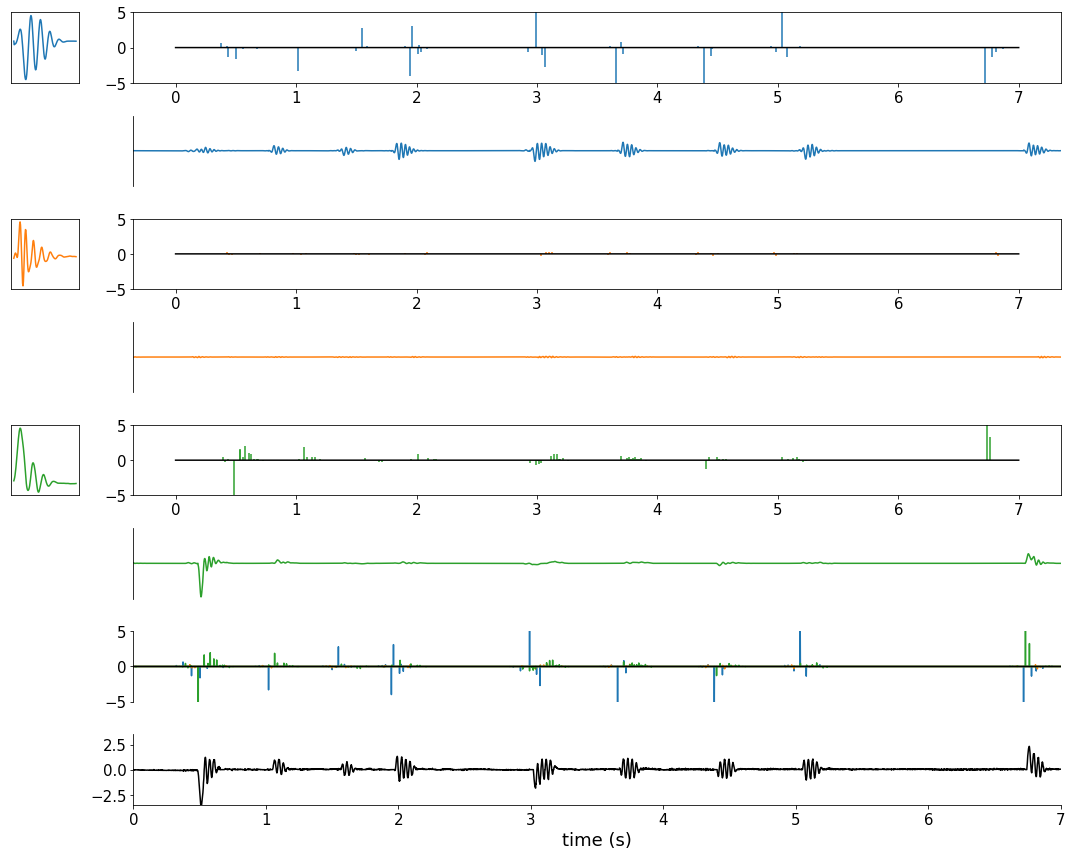

In [98]:
code = np.copy(z)
t = np.arange(0,Duration)/700
id_atom = np.where(np.sum(np.abs(code[IdSt:IdEd,:]),axis=0)>5)[0]

#id_atom = [i for i in ordered_atom if np.any(np.isin(id_atom,i))]
print(id_atom)
N = len(id_atom)
cmap = plt.cm.tab10  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

fig, ax = plt.subplots(facecolor='white',figsize=(15,12),tight_layout=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

G = gridspec.GridSpec(2*N+2,9)

ax = plt.subplot(G[-1:,1:])
ax.plot(t,tail_angle[IdSt:IdEd,7],'k')
ax.set_ylim(-3.5,3.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0,Duration/700)
ax.set_xlabel('time (s)',fontdict={'fontsize':18})
#ax.set_ylabel('tail angle \n (rad)',fontdict={'fontsize':18},rotation='horizontal')

ax = plt.subplot(G[-2,1:])
for i,i_code in enumerate(id_atom):
    ax.plot(t,code[IdSt:IdEd,i_code],color=cmaplist[i])
ax.plot(t,code[IdSt:IdEd,i_code]*0,color='k')
ax.set_xticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlim(0,Duration/700)
ax.set_ylim(-5,5)
#ax.set_ylabel('sparse code',fontdict={'fontsize':18},rotation='horizontal')

# ax.set_ylim(-3,3)
markerline = {}
stemline = {}
k=0
for i,i_code in enumerate(id_atom):
    ax = plt.subplot(G[k,1:])
    ax.plot(t,code[IdSt:IdEd,i_code]*0,color='k')
    y = code[IdSt:IdEd,i_code]
    x = t
    x = x[np.abs(y)>0.1]
    y = y[np.abs(y)>0.1]

    if len(x)>0:
        markerline[i], stemline[i], baseline = ax.stem(x,y,use_line_collection=True)
        baseline.remove()
        markerline[i].remove()
        #plt.setp(markerline[i], color=cmaplist[i]) 
        plt.setp(stemline[i], color=cmaplist[i])
    ax.set_ylim(-5,5)

    
    ax = plt.subplot(G[k+1,1:])
    ax.plot(t,decomposition[IdSt:IdEd,i_code],color=cmaplist[i])
        
    ax.set_ylim(-3.5,3.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xlim(0,Duration/700)

    ax = plt.subplot(G[k:k+1,0])
    ax.plot(Dict[:,-1,i_code],color=cmaplist[i])
    ax.set_xticks([])
    ax.set_yticks([])

    k=k+2


#plt.savefig('SparseCoding_'+strain+'.png',dpi=300, bbox_inches = "tight")

plt.show()